Installing the Necessary Libraries

In [1]:
!pip install nltk
!pip install wordcloud
import nltk
nltk.download('punkt')         # Standard tokenizer data
nltk.download('punkt_tab')     # Additional punkt_tab resource (if available)
nltk.download('stopwords')
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to /home/premraj.d/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/premraj.d/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/premraj.d/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


# Text Review Processing with Dask

This script processes large datasets of text reviews using **Dask** for parallel computing and distributed processing. It converts raw data into a cleaned and structured format suitable for machine learning tasks.

---

## **Processing Functions**

1. **`process_data_dask`**:
   - Splits the raw input into two columns:
     - `label`: Extracted from `__label__X`.
     - `review`: Contains the review text.

2. **`replace_labels`**:
   - Converts the labels to binary format:
     - `2 → 1` (positive sentiment).
     - `1 → 0` (negative sentiment).

3. **`text_cleaning`**:
   - Removes punctuation and converts text to lowercase for standardization.

4. **`clean_reviews`**:
   - Cleans the review text and drops any rows with null values.

---

## **Dask Workflow**

1. Reads large text datasets using `dd.read_csv` and partitions the data for efficient processing.
2. Applies text cleaning and label conversion functions in parallel using Dask’s **`map_partitions`**.
3. Persists the data in memory to optimize processing.
4. Processes the data with Dask's distributed client using 8 workers for parallel computation.

---

## **Performance Monitoring**

- Generates a performance report (`dask_report.html`) to analyze the efficiency of the parallel processing pipeline.

---

## **Output**

- Returns the following:
  - Cleaned **train** and **test** datasets.
  - Total processing time for the pipeline.



In [2]:
import time
import pandas as pd
import dask.dataframe as dd
from dask.distributed import performance_report, Client
import re
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import trange
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
warnings.filterwarnings("ignore")


# Function to process the data and split the label and review text
def process_data_dask(df):
    labels = df[0].str.split(' ', n=1, expand=True)[0].str.replace('__label__', '')
    text = df[0].str.split(' ', n=1, expand=True)[1]

    processed_df = pd.DataFrame({
        'label': labels,
        'review': text.str.strip()
    })
    return processed_df

# Function to replace the labels
def replace_labels(df):
    replace_dict = {"2": "1", "1": "0"}
    df['label'] = df['label'].replace(replace_dict)
    return df

# Text data cleaning
def text_cleaning(text):
    text = text.lower()
    pattern_punc = r'[^A-Za-z\s]'
    text = re.sub(pattern_punc, '', text).strip()
    return text

# Function to clean the reviews and drop null values
def clean_reviews(df):
    df['review'] = df['review'].apply(text_cleaning)
    df = df.dropna()
    return df

# Dask-based processing function with timer
def process_data_with_dask():
    start_time = time.time()  # Start timer
    
    client = Client(n_workers=8, threads_per_worker=1, memory_limit='8GB')
    print("Client Dashboard: ", client.dashboard_link)
  
    train_path = 'train.ft.txt'
    test_path = 'test.ft.txt'

    # Loading data into Dask DataFrame
    train_data_dask = dd.read_csv(train_path, delimiter='\t', header=None, dtype=str)
    test_data_dask = dd.read_csv(test_path, delimiter='\t', header=None, dtype=str)
  
    # Repartition test data to have 4 partitions
    test_data_dask = test_data_dask.repartition(npartitions=4)
  
    # Persist the data in memory
    train_data_dask = train_data_dask.persist()
    test_data_dask = test_data_dask.persist()
  
    meta = pd.DataFrame(columns=['label', 'review'], dtype=str)
  
    # Apply processing functions
    train_data_dask = train_data_dask.map_partitions(process_data_dask, meta=meta)
    test_data_dask = test_data_dask.map_partitions(process_data_dask, meta=meta)
  
    train_data_dask = train_data_dask.map_partitions(replace_labels)
    test_data_dask = test_data_dask.map_partitions(replace_labels)
  
    train_data_dask = train_data_dask.map_partitions(clean_reviews)
    test_data_dask = test_data_dask.map_partitions(clean_reviews)
  
    with performance_report(filename="dask_report.html"):
        train_data_processed = train_data_dask.compute()
        test_data_processed = test_data_dask.compute()
  
    client.close()
    
    end_time = time.time()  # Stop timer
    duration = end_time - start_time  # Calculate duration
    
    print(f"Dask processing time: {duration} seconds")
    
    return train_data_processed, test_data_processed, duration



# Text Review Processing with Pandas

This script processes large datasets of text reviews using **Pandas** for efficient data manipulation and cleaning. It transforms raw data into a structured format suitable for machine learning tasks.

---

## **Processing Functions**

1. **`process_data_pandas`**:
   - Splits the raw input into two columns:
     - `label`: Extracted from `__label__X`.
     - `review`: Contains the review text.

2. **`replace_labels`**:
   - Converts the labels to binary format:
     - `2 → 1` (positive sentiment).
     - `1 → 0` (negative sentiment).

3. **`text_cleaning`**:
   - Removes punctuation and converts text to lowercase for standardization.

4. **`clean_reviews`**:
   - Cleans the review text and drops any rows with null values.

---

## **Pandas Workflow**

1. Loads data from text files into Pandas DataFrames using **`pd.read_csv`**.
2. Applies the following processing steps:
   - Splits and organizes the data into labels and review columns.
   - Replaces original labels with binary values.
   - Cleans the review text to remove punctuation and ensure consistency.
3. Executes all transformations sequentially using Pandas' built-in operations.

---

## **Performance Monitoring**

- Measures and prints the total processing time for the Pandas-based pipeline.

---

## **Output**

- Returns the following:
  - Cleaned **train** and **test** datasets.
  - Total processing time for the pipeline.

---

## **Note**

- Ignore any warnings displayed during the execution of the script as they do not impact the functionality or output.

  - Total processing time for the pipeline.



In [3]:
import time
import pandas as pd
import re

# Function to process the data and split the label and review text
def process_data_pandas(df):
    labels = df[0].str.split(' ', n=1, expand=True)[0].str.replace('__label__', '')
    text = df[0].str.split(' ', n=1, expand=True)[1]

    processed_df = pd.DataFrame({
        'label': labels,
        'review': text.str.strip()
    })
    return processed_df

# Function to replace the labels
def replace_labels(df):
    replace_dict = {"2": "1", "1": "0"}
    df['label'] = df['label'].replace(replace_dict)
    return df

# Text data cleaning
def text_cleaning(text):
    text = text.lower()
    pattern_punc = r'[^A-Za-z\s]'
    text = re.sub(pattern_punc, '', text).strip()
    return text

# Function to clean the reviews and drop null values
def clean_reviews(df):
    df['review'] = df['review'].apply(text_cleaning)
    df = df.dropna()
    return df

# Pandas-based processing function with timer
def process_data_with_pandas():
    start_time = time.time()  # Start timer
    
    train_path = 'train.ft.txt'
    test_path = 'test.ft.txt'

    # Load data into pandas DataFrame
    train_data = pd.read_csv(train_path, delimiter='\t', header=None, dtype=str)
    test_data = pd.read_csv(test_path, delimiter='\t', header=None, dtype=str)

    # Apply processing functions
    train_data = process_data_pandas(train_data)
    test_data = process_data_pandas(test_data)
  
    train_data = replace_labels(train_data)
    test_data = replace_labels(test_data)
  
    train_data = clean_reviews(train_data)
    test_data = clean_reviews(test_data)
    
    end_time = time.time()  # Stop timer
    duration = end_time - start_time  # Calculate duration
    
    print(f"Pandas processing time: {duration} seconds")
    
    return train_data, test_data, duration


In [4]:
# DataFrame to store timing results
timing_results_df = pd.DataFrame(columns=["Run_ID", "Method", "Processing_Time_Seconds"])

# Function to log timing result to DataFrame
def log_timing_result(run_id, method, duration):
    global timing_results_df
    new_entry = pd.DataFrame({
        "Run_ID": [run_id],
        "Method": [method],
        "Processing_Time_Seconds": [duration]
    })
    timing_results_df = pd.concat([timing_results_df, new_entry], ignore_index=True)
    return timing_results_df

# Main function
if __name__ == "__main__":
    # Run the Dask version
    train_data_processed_dask, test_data_processed_dask, duration_dask = process_data_with_dask()
    if train_data_processed_dask is not None and test_data_processed_dask is not None:
        print("Dask Data Processing Done")
        
        # Log the timing result for the Dask method
        run_id = len(timing_results_df) + 1
        timing_results_df = log_timing_result(run_id, "Dask", duration_dask)
        
    # Run the Pandas version
    train_data_processed_pandas, test_data_processed_pandas, duration_pandas = process_data_with_pandas()
    if train_data_processed_pandas is not None and test_data_processed_pandas is not None:
        print("Pandas Data Processing Done")
        
        # Log the timing result for the Pandas method
        run_id = len(timing_results_df) + 1
        timing_results_df = log_timing_result(run_id, "Pandas", duration_pandas)
        
    # Display the DataFrame with timing results
    print(timing_results_df)
    
    # Save the DataFrame to a CSV for future reference
    timing_results_df.to_csv("timing_results.csv", index=False)


Client Dashboard:  http://127.0.0.1:8787/status


2024-11-24 18:45:29,228 - distributed.sizeof - WARNING - Sizeof calculation for object of type 'dict' failed. Defaulting to -1 B
Traceback (most recent call last):
  File "/home/premraj.d/.local/lib/python3.11/site-packages/distributed/sizeof.py", line 17, in safe_sizeof
    return sizeof(obj)
           ^^^^^^^^^^^
  File "/home/premraj.d/.local/lib/python3.11/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/premraj.d/.local/lib/python3.11/site-packages/dask/sizeof.py", line 96, in sizeof_python_dict
    + sizeof(list(d.values()))
      ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/premraj.d/.local/lib/python3.11/site-packages/dask/utils.py", line 773, in __call__
    return meth(arg, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/premraj.d/.local/lib/python3.11/site-packages/dask/sizeof.py", line 59, in sizeof_python_collection
    return sys.getsizeof(seq) + sum(map(sizeof, se

Dask processing time: 31.7303364276886 seconds
Dask Data Processing Done
Pandas processing time: 79.26881098747253 seconds
Pandas Data Processing Done
  Run_ID  Method  Processing_Time_Seconds
0      1    Dask                31.730336
1      2  Pandas                79.268811


In [5]:
timing_results_df

,Run_ID,Method,Processing_Time_Seconds
0,1,Dask,31.730336
1,2,Pandas,79.268811


# Processing Time Comparison Visualization

The bar chart visualizes the processing time comparison between **Dask** and **Pandas**. It clearly shows that Dask significantly outperforms Pandas in terms of processing speed for this workload.

- **Dask**: Processes the dataset faster, demonstrating the benefits of parallel computing.
- **Pandas**: Takes more time due to its sequential data processing nature.

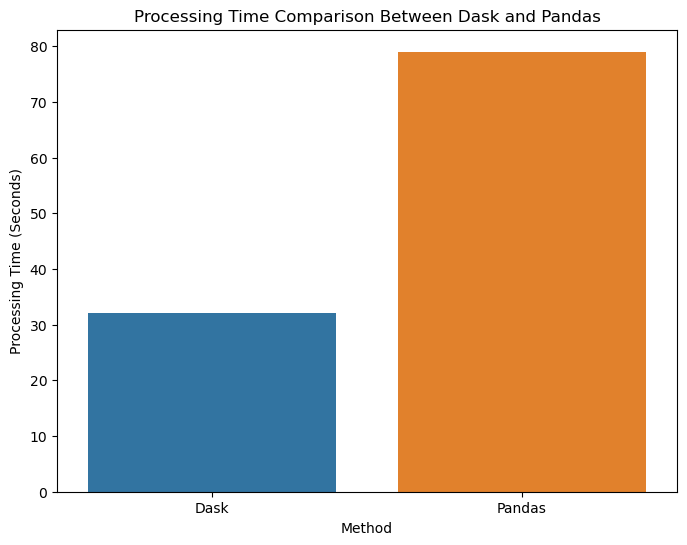

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Round the Processing_Time_Seconds column to the nearest integer
timing_results_df["Processing_Time_Seconds"] = timing_results_df["Processing_Time_Seconds"].round().astype(int)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x="Method", y="Processing_Time_Seconds", data=timing_results_df)
plt.title("Processing Time Comparison Between Dask and Pandas")
plt.xlabel("Method")
plt.ylabel("Processing Time (Seconds)")
plt.show()


In [7]:
train_data_processed_dask

,label,review
0,1,stuning even for the nongamer this sound track...
1,1,the best soundtrack ever to anything im readin...
2,1,amazing this soundtrack is my favorite music o...
3,1,excellent soundtrack i truly like this soundtr...
4,1,remember pull your jaw off the floor after hea...
...,...,...
151052,0,dont do it the high chair looks great when it ...
151053,0,looks nice low functionality i have used this ...
151054,0,compact but hard to clean we have a small hous...
151055,0,what is it saying not sure what this book is s...


# Data Inspection 

This section demonstrates inspecting the processed datasetand , performing data analyss.

---

## **Steps Performed**

1. **Checking for Null Values:**
   - Used `.isnull().sum()` to verify if there are any missing values in the dataset. 
   - Outcome: No null values in the `label` or `review` columns.

2. **Dataset Overview:**
   - Used `.info()` to display the structure and memory usage of the dataset.
   - Outcome: 
     - The dataset contains 360,000 entries split across 2 columns (`label` and `review`).
     - Both columns are stored as `object` datatype.

3. **Class Distribution:**
   - Used `.value_counts()` to check the distribution of labels (`1` for positive and `0` for negative reviews).
   - Outcome: 
     - Balanced dataset with an equal number of positive (`1,800,000`) and negative (`te4 value for each review.

5. **Preview of Processed Data:**
   - Displayed the first few rows of the dataset using `.head()`:
     - Columns: `label`, `review`, and the newly added `mean_review_length`.

---

## **Key Insights**
- The dataset is balanced, with no missing valuehts into the complexity of reviews.


In [8]:
train_data_processed_dask.isnull().sum()

label     0
review    0
dtype: int64

In [9]:
train_data_processed_dask.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3600000 entries, 0 to 151056
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   review  object
dtypes: object(2)
memory usage: 82.4+ MB


In [10]:
train_data_processed_dask['label'].value_counts()


label
1    1800000
0    1800000
Name: count, dtype: int64

In [11]:
from nltk.tokenize import sent_tokenize

train_data_processed_dask['mean_review_length'] = train_data_processed_dask['review'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))


In [12]:
train_data_processed_dask.head()

,label,review,mean_review_length
0,1,stuning even for the nongamer this sound track...,414.0
1,1,the best soundtrack ever to anything im readin...,495.0
2,1,amazing this soundtrack is my favorite music o...,719.0
3,1,excellent soundtrack i truly like this soundtr...,710.0
4,1,remember pull your jaw off the floor after hea...,459.0


In [13]:
!pip install wordcloud
from wordcloud import WordCloud

Defaulting to user installation because normal site-packages is not writeable


# Visual Analysis of Text Reviews

This section explores the dataset through various visualizations, focusing on word frequencies, bigrams, and review characteristics for better understanding.

---

## **Word Cloud for Labels**

1. **Word Cloud for Label 1:**
   - Visualizes the most frequent words in positive reviews (`Label 1`).
   - Common words include "book," "movie," "love," and "one."

2. **Word Cloud for Label 0:**
   - Visualizes the most frequent words in negative reviews (`Label 0`).
   - Common words include "book," "movie," "one," and "problem."

---

## **Top 10 Most Frequently Occurring Words**

- Displays a bar chart of the top 10 most frequently occurring words in the dataset.
- Common words include:
  - **Positive Words**: "book," "one," "great," "good."
  - **Neutral Words**: "like," "would," "time."

---

## **Top 10 Most Frequently Occurring Bigrams**

- Shows the most common bigrams (two-word phrases) in the dataset:
  - "dont waste money."
  - "dont waste time."
  - "would recommend book."
  - Indicates repetitive themes in customer feedback.

---

## **Review Length Distribution**

- Compares the distribution of review lengths (in characters) for `Label 1` (positive) and `Label 0` (negative):
  - Positive reviews (Label 1) tend to be slightly longer on average than negative reviews (Label 0).
  - Review length distribution helps identify potential biases or trends in review patterns.

---

## **Key Insights**

- Word clouds and frequency charts highlight common sentiments and repetitive themes in reviews.
- Positive reviews often emphasize enjoyment and recommendations.
- Negative reviews frequently mention dissatisfaction and problems with the product or service.
- Bigram analysis provides additional context by revealing common phrases.
- The distribution of review lengths shows that review characteristics differ slightly between positive and negative reviews.


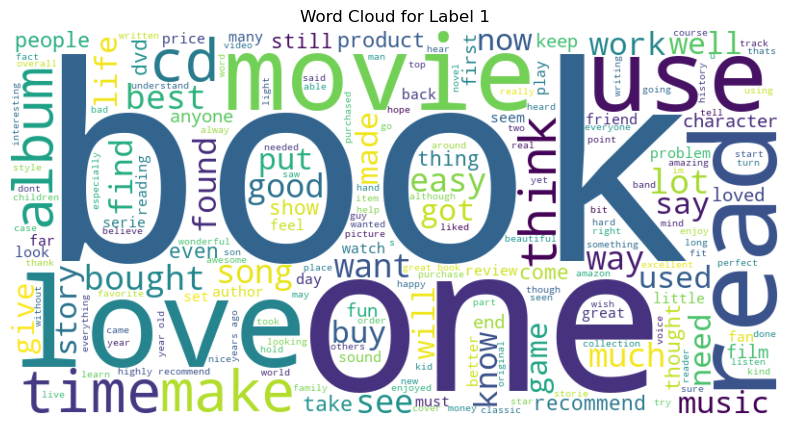

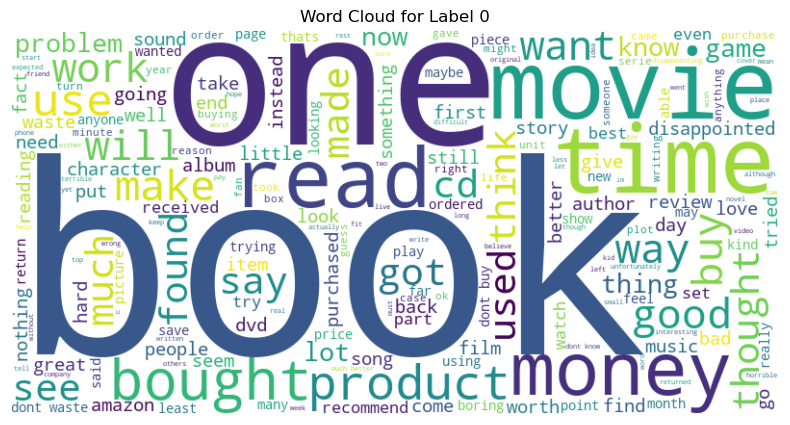

In [14]:
for label in train_data_processed_dask['label'].unique():
    label_reviews = " ".join(review for review in train_data_processed_dask[train_data_processed_dask['label'] == label]["review"])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(label_reviews)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Label {label}")
    plt.show()

In [15]:
stop_words = set(stopwords.words('english'))

# Function to remove stop words from a sentence
def remove_stop_words(text):
    words = word_tokenize(text)  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [16]:
train_data_processed_dask['review'] = train_data_processed_dask['review'].apply(remove_stop_words)

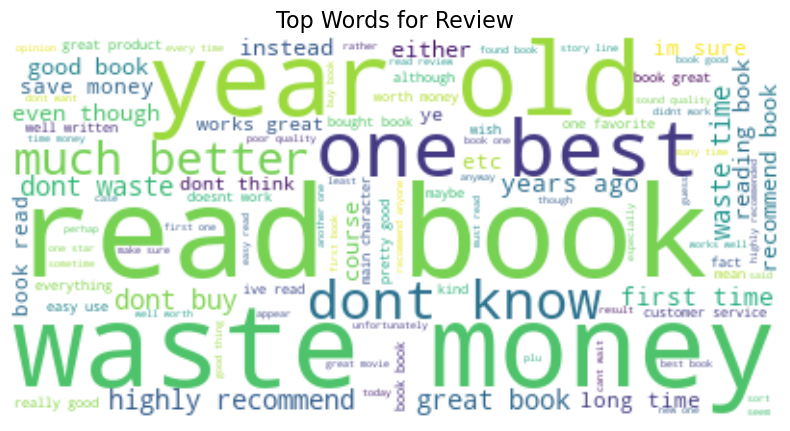

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentences = train_data_processed_dask['review'].tolist()
sentences_as_one_string = " ".join(sentences)

plt.figure(figsize=(10, 5))
plt.title('Top Words for Review', fontsize=16)
wordcloud = WordCloud(background_color='white').generate(sentences_as_one_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()


In [18]:
def corpus(text):
    text_list = text.split()
    return text_list

In [19]:
train_data_processed_dask['Review_lists'] = train_data_processed_dask['review'].apply(corpus)
train_data_processed_dask.head(10)

,label,review,mean_review_length,Review_lists
0,1,stuning even nongamer sound track beautiful pa...,414.0,"[stuning, even, nongamer, sound, track, beauti..."
1,1,best soundtrack ever anything im reading lot r...,495.0,"[best, soundtrack, ever, anything, im, reading..."
2,1,amazing soundtrack favorite music time hands i...,719.0,"[amazing, soundtrack, favorite, music, time, h..."
3,1,excellent soundtrack truly like soundtrack enj...,710.0,"[excellent, soundtrack, truly, like, soundtrac..."
4,1,remember pull jaw floor hearing youve played g...,459.0,"[remember, pull, jaw, floor, hearing, youve, p..."
5,1,absolute masterpiece quite sure actually takin...,788.0,"[absolute, masterpiece, quite, sure, actually,..."
6,0,buyer beware selfpublished book want know whyr...,703.0,"[buyer, beware, selfpublished, book, want, kno..."
7,1,glorious story loved whisper wicked saints sto...,509.0,"[glorious, story, loved, whisper, wicked, sain..."
8,1,five star book finished reading whisper wicked...,513.0,"[five, star, book, finished, reading, whisper,..."
9,1,whispers wicked saints easy read book made wan...,293.0,"[whispers, wicked, saints, easy, read, book, m..."


In [20]:
import pandas as pd
from tqdm import tqdm

review_lists = train_data_processed_dask['Review_lists']

# Initialize corpus
corpus = []

# Flatten the list of lists
for review_list in tqdm(review_lists, ncols=150, colour='green', smoothing=0.8):
    corpus += review_list  # Assuming each row contains a list of reviews

# Get the length of the corpus
corpus_length = len(corpus)
print(f"Length of corpus: {corpus_length}")



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3600000/3600000 [00:03<00:00, 1100955.65it/s]

Length of corpus: 144303649


In [21]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('book', 1926813),
 ('one', 1324894),
 ('great', 1051925),
 ('good', 1016873),
 ('like', 1016574),
 ('would', 834672),
 ('get', 684928),
 ('read', 681780),
 ('time', 645253),
 ('dont', 622442)]

In [22]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

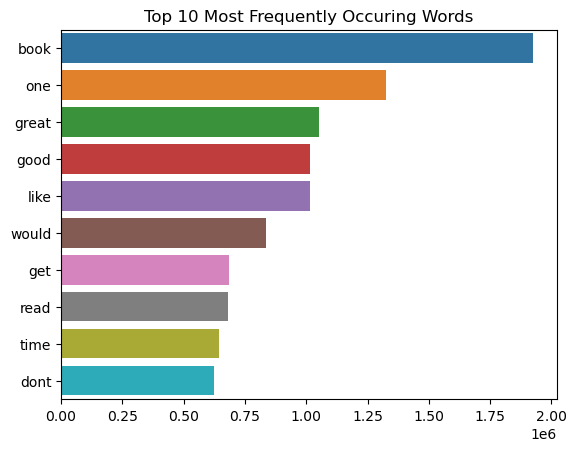

In [23]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [24]:
cv = CountVectorizer(ngram_range=(3,3))
bigrams = cv.fit_transform(train_data_processed_dask['review'])

In [25]:
count_values = bigrams.sum(axis=0).A1  # `.A1` flattens the sparse matrix to a 1D array

# Create a DataFrame of ngram frequencies
ngram_freq = pd.DataFrame(
    sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True),
    columns=["frequency", "ngram"]
)


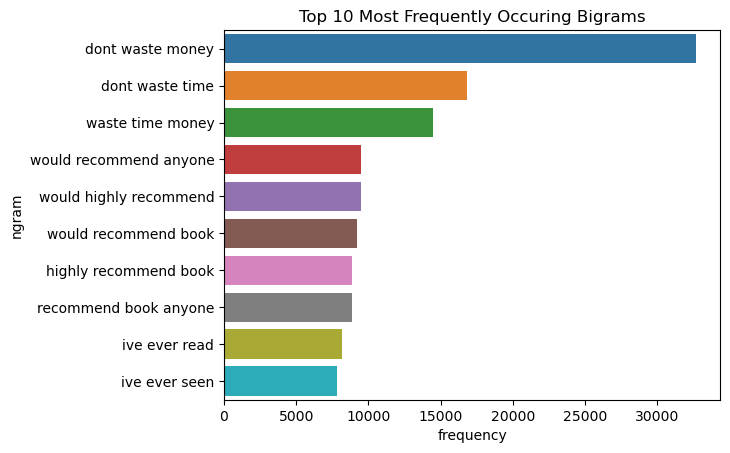

In [26]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [27]:
timing_results_df

,Run_ID,Method,Processing_Time_Seconds
0,1,Dask,32
1,2,Pandas,79


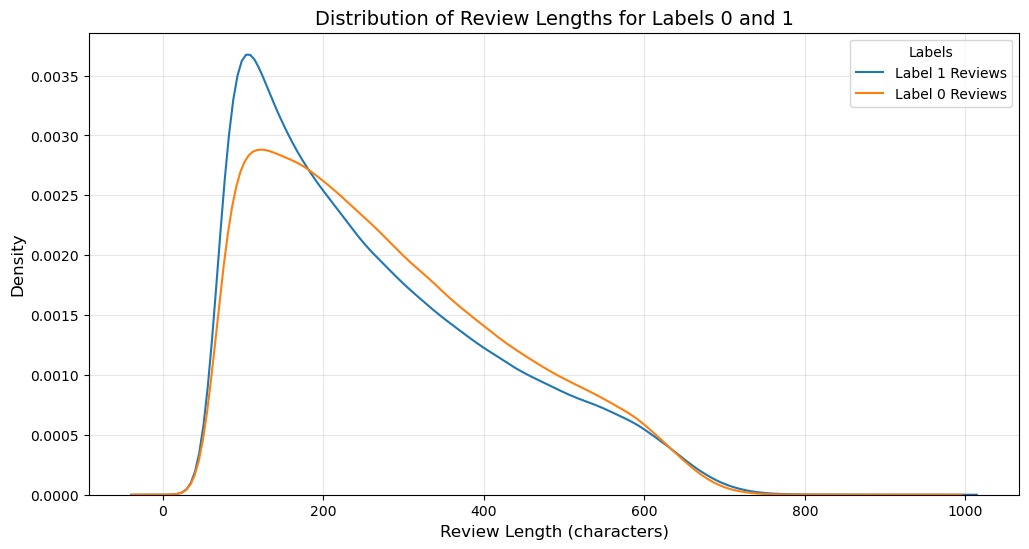

In [28]:
train_data_processed_dask['review_length'] = train_data_processed_dask['review'].str.len()

df = train_data_processed_dask
label1_reviews = df[df['label'] == '1']
label0_reviews = df[df['label'] == '0']

plt.figure(figsize=(12, 6))
sns.kdeplot(label1_reviews['review_length'], label='Label 1 Reviews', bw_adjust=1.5)
sns.kdeplot(label0_reviews['review_length'], label='Label 0 Reviews', bw_adjust=1.5)

plt.title("Distribution of Review Lengths for Labels 0 and 1", fontsize=14)
plt.xlabel("Review Length (characters)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Labels", fontsize=10)
plt.grid(alpha=0.3)
plt.show()